# Number classifier

The goal of this notebook is to train a model for classify the numbers detected in players shirt

## Load packages

In [10]:
import tensorflow as tf
from keras.applications import VGG16
from keras.layers import (Flatten, Dense, Dropout, Input, Conv2D, MaxPooling2D,
                                      RandomRotation, RandomTranslation, RandomZoom, RandomFlip)
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import cv2
import os
import imutils
import pickle
import seaborn as sns
import yaml

In [5]:
from pathlib import Path

# Set paths for local Windows environment
base_path = Path('./Shirt-number-Recognition-1')
output_path = Path('./models')  # Local path to save models
output_path.mkdir(exist_ok=True)

# Load class names from data.yaml
with open(base_path / 'data.yaml', 'r') as f:
    data_config = yaml.safe_load(f)
    class_names = data_config['names']  # List of shirt numbers as strings
    num_classes = len(class_names)

print(f"Number of classes: {num_classes}")
print(f"Class names: {class_names}")

Number of classes: 36
Class names: ['10', '11', '12', '14', '15', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '29', '3', '30', '31', '32', '33', '34', '35', '4', '41', '47', '49', '5', '53', '6', '7', '8', '87', '9']


## Load data paths and data

In [6]:
# Define paths for train, validation, and test sets
train_path = base_path / 'train'
valid_path = base_path / 'valid'
test_path = base_path / 'test'

def load_classification_data(data_path, class_names, target_size=(224, 224)):
    """
    Load images and class labels from YOLO format dataset for classification.
    Crops the bounding box region from each image for number classification.
    """
    images = []
    labels = []
    filenames = []
    
    images_path = data_path / 'images'
    labels_path = data_path / 'labels'
    
    # Get all image files
    image_extensions = ['*.jpg', '*.jpeg', '*.png']
    image_files = []
    for ext in image_extensions:
        image_files.extend(list(images_path.glob(ext)))
    
    for img_file in image_files:
        # Find corresponding label file
        label_file = labels_path / (img_file.stem + '.txt')
        
        if not label_file.exists():
            continue
        
        # Read original image to get dimensions for cropping
        try:
            original_img = cv2.imread(str(img_file))
            if original_img is None:
                continue
            orig_h, orig_w = original_img.shape[:2]
        except Exception as e:
            print(f"Error loading image {img_file}: {e}")
            continue
        
        # Read all bounding boxes from label file
        with open(label_file, 'r') as f:
            lines = f.readlines()
            
            for line in lines:
                parts = line.strip().split()
                if len(parts) >= 5:
                    # YOLO format: class_id x_center y_center width height
                    class_id = int(parts[0])
                    x_center = float(parts[1])
                    y_center = float(parts[2])
                    width = float(parts[3])
                    height = float(parts[4])
                    
                    # Convert normalized coords to pixel coords
                    x1 = int((x_center - width / 2) * orig_w)
                    y1 = int((y_center - height / 2) * orig_h)
                    x2 = int((x_center + width / 2) * orig_w)
                    y2 = int((y_center + height / 2) * orig_h)
                    
                    # Clip to image boundaries
                    x1 = max(0, x1)
                    y1 = max(0, y1)
                    x2 = min(orig_w, x2)
                    y2 = min(orig_h, y2)
                    
                    # Skip if crop is too small
                    if x2 - x1 < 5 or y2 - y1 < 5:
                        continue
                    
                    # Crop the bounding box region
                    crop = original_img[y1:y2, x1:x2]
                    
                    # Resize to target size
                    crop_resized = cv2.resize(crop, target_size)
                    
                    # Convert BGR to RGB and normalize
                    crop_rgb = cv2.cvtColor(crop_resized, cv2.COLOR_BGR2RGB)
                    crop_normalized = crop_rgb.astype('float32') / 255.0
                    
                    images.append(crop_normalized)
                    labels.append(class_id)
                    filenames.append(str(img_file))
    
    return np.array(images), np.array(labels), filenames

# Load training data
print("[INFO] Loading training data...")
X_train_raw, y_train_raw, train_filenames = load_classification_data(train_path, class_names)
print(f"Loaded {len(X_train_raw)} training samples")

# Load validation data
print("[INFO] Loading validation data...")
X_valid_raw, y_valid_raw, valid_filenames = load_classification_data(valid_path, class_names)
print(f"Loaded {len(X_valid_raw)} validation samples")

# Load test data
print("[INFO] Loading test data...")
X_test_raw, y_test_raw, test_filenames = load_classification_data(test_path, class_names)
print(f"Loaded {len(X_test_raw)} test samples")

# If test set is empty, use validation set for testing
if len(X_test_raw) == 0:
    print("[INFO] Test set is empty, using validation set for testing")
    X_test_raw = X_valid_raw
    y_test_raw = y_valid_raw
    test_filenames = valid_filenames

# Combine train and validation for training (or keep separate)
X_train = X_train_raw
y_train = y_train_raw

# Use validation as test
X_test = X_valid_raw if len(X_test_raw) == 0 else X_test_raw
y_test = y_valid_raw if len(y_test_raw) == 0 else y_test_raw

# Convert labels to one-hot encoding
y_train = to_categorical(y_train, num_classes=num_classes)
y_test = to_categorical(y_test, num_classes=num_classes)

print(f"\nData shapes:")
print(f"  X_train: {X_train.shape}")
print(f"  y_train: {y_train.shape}")
print(f"  X_test: {X_test.shape}")
print(f"  y_test: {y_test.shape}")

[INFO] Loading training data...
Loaded 504 training samples
[INFO] Loading validation data...
Loaded 11 validation samples
[INFO] Loading test data...
Loaded 94 test samples

Data shapes:
  X_train: (504, 224, 224, 3)
  y_train: (504, 36)
  X_test: (94, 224, 224, 3)
  y_test: (94, 36)
Loaded 504 training samples
[INFO] Loading validation data...
Loaded 11 validation samples
[INFO] Loading test data...
Loaded 94 test samples

Data shapes:
  X_train: (504, 224, 224, 3)
  y_train: (504, 36)
  X_test: (94, 224, 224, 3)
  y_test: (94, 36)


## Dataset samples

In [7]:
# Check shape of a sample image
print(f"Sample image shape: {X_train[0].shape}")
print(f"Sample label (one-hot): {y_train[0]}")
print(f"Sample class index: {np.argmax(y_train[0])}")
print(f"Sample class name: {class_names[np.argmax(y_train[0])]}")

Sample image shape: (224, 224, 3)
Sample label (one-hot): [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Sample class index: 15
Sample class name: 26


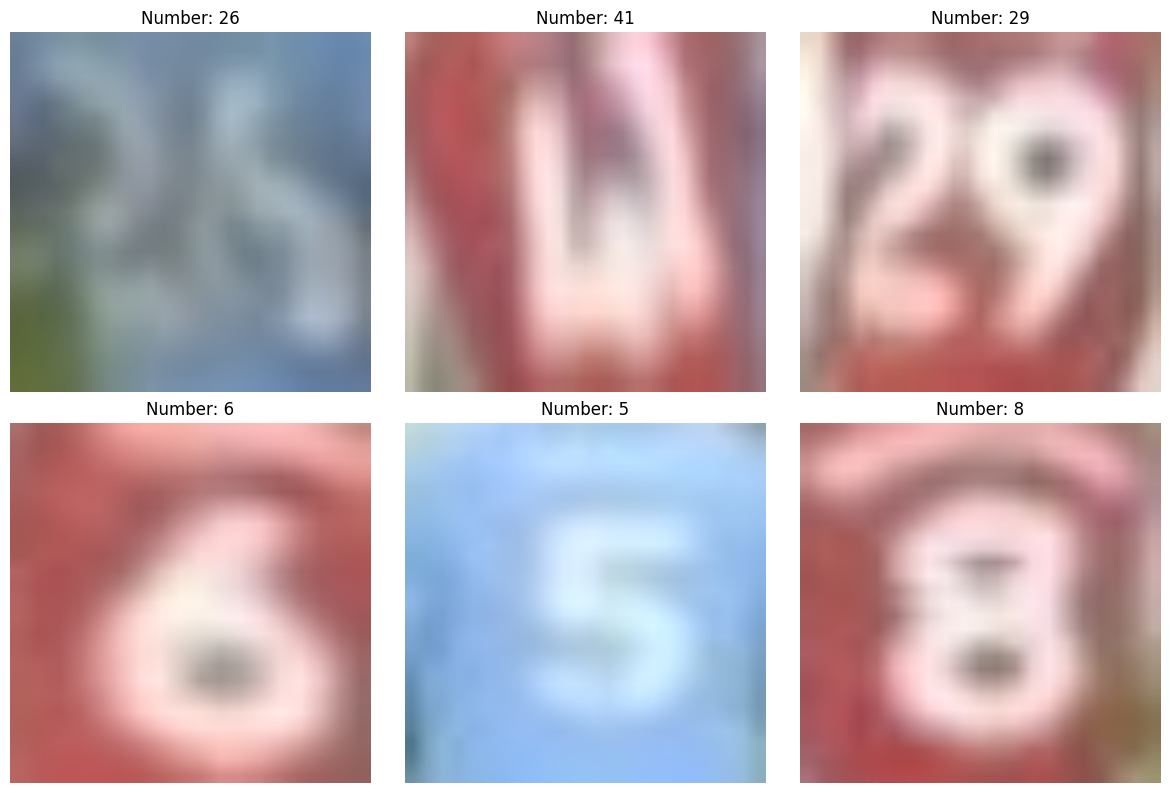

In [8]:
# Examples of cropped number images with their labels
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.ravel()

for ind in range(min(6, len(X_train))):
    axes[ind].imshow(X_train[ind])
    class_idx = np.argmax(y_train[ind])
    axes[ind].set_title(f'Number: {class_names[class_idx]}')
    axes[ind].axis('off')

plt.tight_layout()
plt.show()

## Model architecture

In [9]:
# CNN architecture for number classification

# Initialising the CNN
classifier = Sequential()

classifier.add(Conv2D(128, (3, 3), input_shape=(224, 224, 3), activation='relu'))
classifier.add(MaxPooling2D(pool_size=(2, 2)))
classifier.add(Dropout(0.2))

classifier.add(Conv2D(64, (3, 3), activation='relu'))
classifier.add(MaxPooling2D(pool_size=(2, 2)))
classifier.add(Dropout(0.2))

classifier.add(Conv2D(64, (3, 3), activation='relu'))
classifier.add(MaxPooling2D(pool_size=(2, 2)))
classifier.add(Dropout(0.2))

classifier.add(Conv2D(64, (3, 3), activation='relu'))
classifier.add(MaxPooling2D(pool_size=(2, 2)))
classifier.add(Dropout(0.2))

classifier.add(Conv2D(32, (3, 3), activation='relu'))
classifier.add(MaxPooling2D(pool_size=(2, 2)))
classifier.add(Dropout(0.2))

classifier.add(Flatten())

classifier.add(Dense(units=128, activation='relu'))
classifier.add(Dense(units=64, activation='relu'))
classifier.add(Dense(units=64, activation='relu'))
classifier.add(Dense(units=num_classes, activation='softmax'))  # Dynamic number of classes

# Compiling the CNN
classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

print(classifier.summary())

c:\Users\Usuario\Downloads\train yolo\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 128)  │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 111, 111, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 10, 10, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 5, 5, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 5, 5, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 800)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       102,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 36)             │         2,340 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 286,980 (1.09 MB)

 Trainable params: 286,980 (1.09 MB)

 Non-trainable params: 0 (0.00 B)

None


In [11]:
# Data Augmentation using Keras preprocessing layers (replaces deprecated ImageDataGenerator)
data_augmentation = Sequential([
    RandomRotation(0.1),  # rotation_range=30 degrees ~ 0.08 radians
    RandomTranslation(height_factor=0.2, width_factor=0.2),
    RandomZoom(0.1),
], name='data_augmentation')

# Training parameters
epochs = 50  # Reduced for faster training, increase as needed
batch_size = 32

# Create tf.data.Dataset for efficient training
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=len(X_train))
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x, training=True), y))
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = test_dataset.batch(batch_size)
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

# Train the model
print("[INFO] Training classifier...")
H = classifier.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=epochs,
    verbose=1
)

[INFO] Training classifier...
Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 596ms/step - accuracy: 0.0655 - loss: 3.5025 - val_accuracy: 0.0957 - val_loss: 3.4899
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 596ms/step - accuracy: 0.0655 - loss: 3.5025 - val_accuracy: 0.0957 - val_loss: 3.4899
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 572ms/step - accuracy: 0.0893 - loss: 3.3820 - val_accuracy: 0.0957 - val_loss: 3.4086
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 572ms/step - accuracy: 0.0893 - loss: 3.3820 - val_accuracy: 0.0957 - val_loss: 3.4086
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 563ms/step - accuracy: 0.0893 - loss: 3.3296 - val_accuracy: 0.0957 - val_loss: 3.4413
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 563ms/step - accuracy: 0.0893 - loss: 3.3296 - val_accuracy: 0.0957 - val_loss: 3.4413
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 555ms/step - accuracy: 0.0794 - loss: 3.2967 - val_accuracy: 0.0745 - val_loss: 3.4443
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 555ms/step - accuracy: 0.0794 -

In [12]:
# Save model to local output path
model_path = output_path / 'numbers_classifier.h5'
classifier.save(model_path)
print(f"Model saved to {model_path}")

# Also save class names for later use
class_names_path = output_path / 'class_names.pkl'
with open(class_names_path, 'wb') as f:
    pickle.dump(class_names, f)
print(f"Class names saved to {class_names_path}")

Model saved to models\numbers_classifier.h5
Class names saved to models\class_names.pkl


## Plot performance

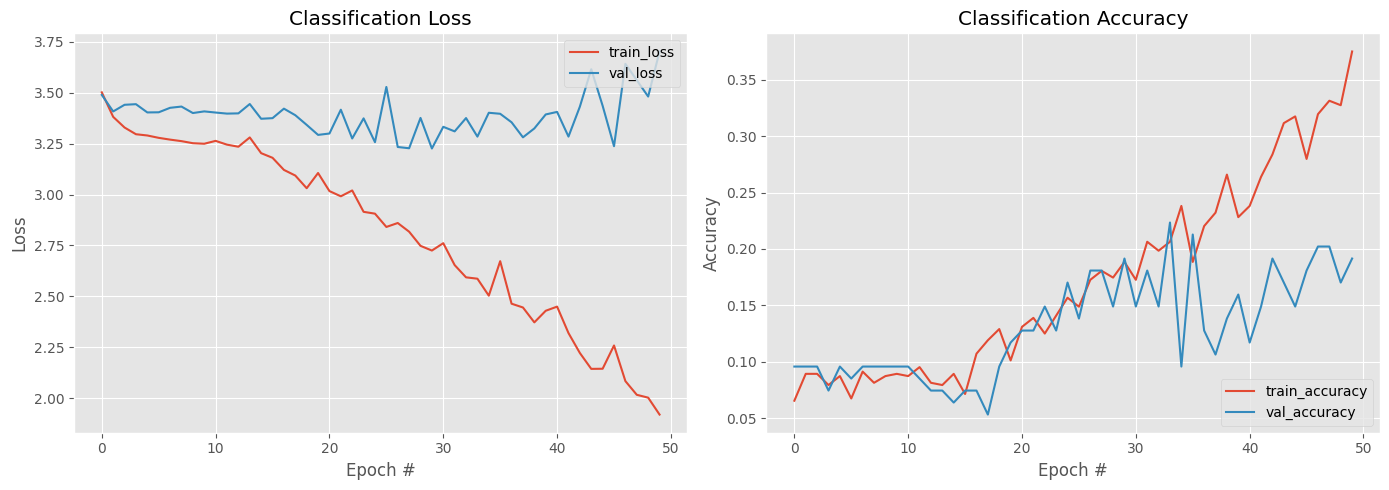

In [13]:
# Plot the model training history
N = epochs
plt.style.use("ggplot")
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss plot
axes[0].plot(np.arange(0, N), H.history["loss"], label="train_loss")
axes[0].plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
axes[0].set_title("Classification Loss")
axes[0].set_xlabel("Epoch #")
axes[0].set_ylabel("Loss")
axes[0].legend(loc="upper right")

# Accuracy plot
axes[1].plot(np.arange(0, N), H.history["accuracy"], label="train_accuracy")
axes[1].plot(np.arange(0, N), H.history["val_accuracy"], label="val_accuracy")
axes[1].set_title("Classification Accuracy")
axes[1].set_xlabel("Epoch #")
axes[1].set_ylabel("Accuracy")
axes[1].legend(loc="lower right")

plt.tight_layout()
plt.show()

### Confusion Matrix

In [14]:
# Generate predictions for confusion matrix
print("[INFO] Generating predictions on test set...")
predictions = classifier.predict(X_test, verbose=0)

# Get predicted and actual class indices
pred_classes = np.argmax(predictions, axis=1)
real_classes = np.argmax(y_test, axis=1)

print(f"Total test samples: {len(pred_classes)}")

[INFO] Generating predictions on test set...
Total test samples: 94
Total test samples: 94


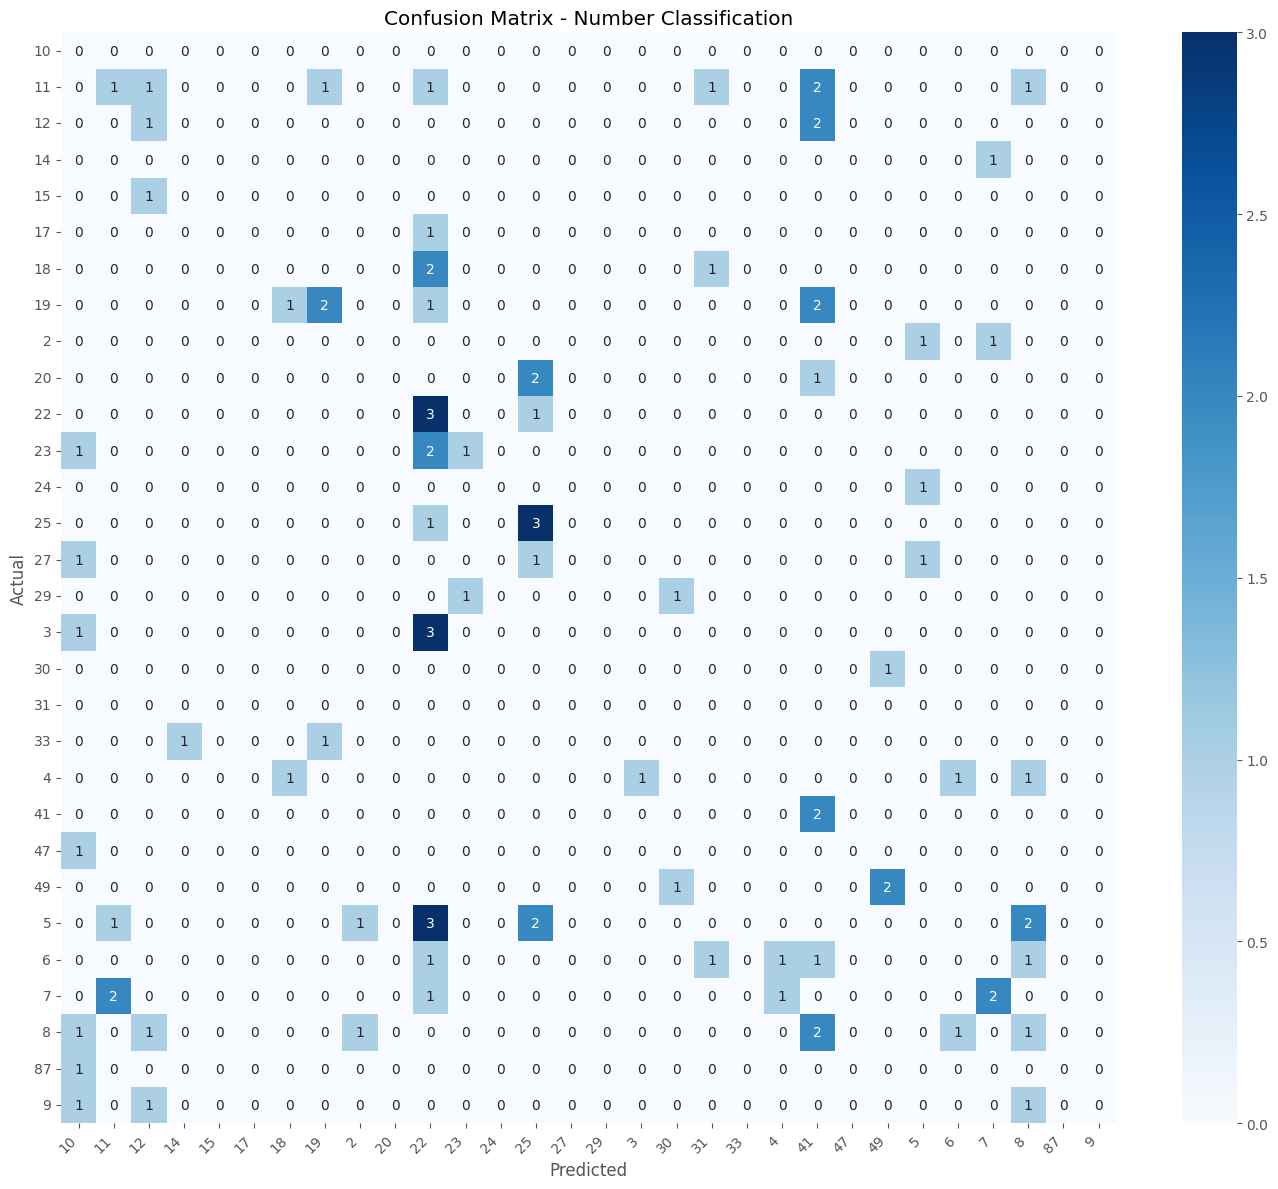


Classification Report:
              precision    recall  f1-score   support

          10       0.00      0.00      0.00         0
          11       0.25      0.12      0.17         8
          12       0.20      0.33      0.25         3
          14       0.00      0.00      0.00         1
          15       0.00      0.00      0.00         1
          17       0.00      0.00      0.00         1
          18       0.00      0.00      0.00         3
          19       0.50      0.33      0.40         6
           2       0.00      0.00      0.00         2
          20       0.00      0.00      0.00         3
          22       0.16      0.75      0.26         4
          23       0.50      0.25      0.33         4
          24       0.00      0.00      0.00         1
          25       0.33      0.75      0.46         4
          27       0.00      0.00      0.00         3
          29       0.00      0.00      0.00         2
           3       0.00      0.00      0.00         4
   

In [16]:
# Create confusion matrix
from sklearn.metrics import confusion_matrix, classification_report

# Get unique classes present in the data
unique_classes = np.unique(np.concatenate([real_classes, pred_classes]))
present_class_names = [class_names[i] for i in unique_classes]

# Create DataFrame for confusion matrix
data = {
    'y_Actual': real_classes,
    'y_Predicted': pred_classes
}
df = pd.DataFrame(data)

# Generate confusion matrix with explicit labels
cm = confusion_matrix(real_classes, pred_classes, labels=unique_classes)

# Plot confusion matrix
plt.figure(figsize=(14, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=present_class_names, yticklabels=present_class_names)
plt.title('Confusion Matrix - Number Classification')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Print classification report with only present classes
print("\nClassification Report:")
print(classification_report(real_classes, pred_classes, 
                            labels=unique_classes, 
                            target_names=present_class_names, 
                            zero_division=0))

### Plot example

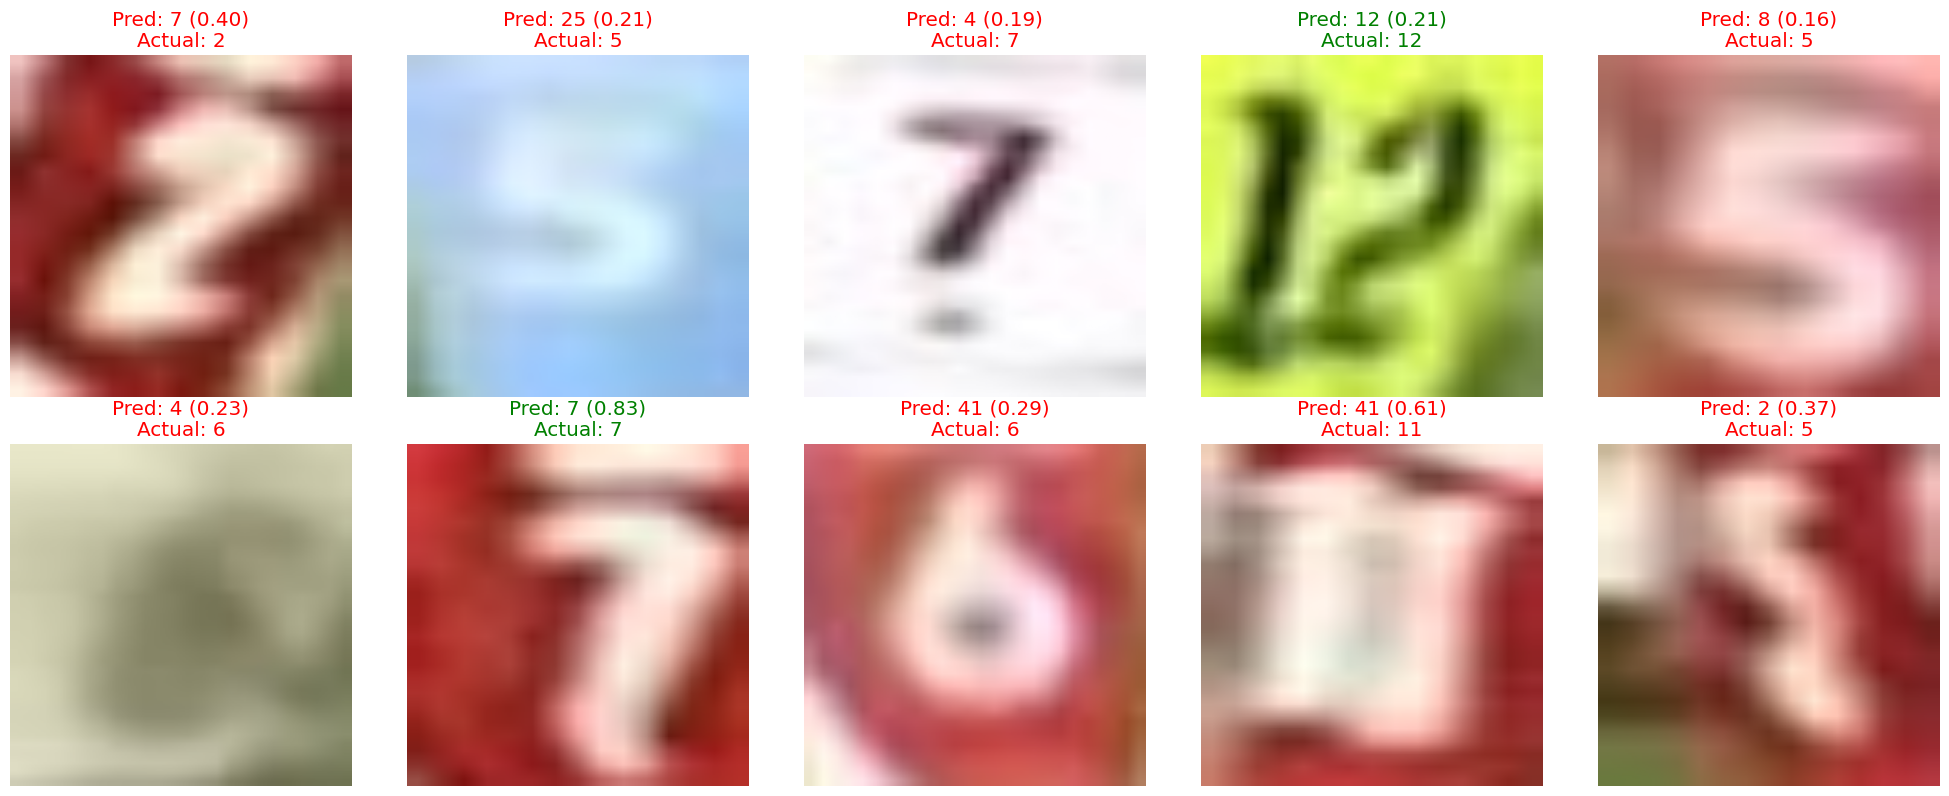

In [17]:
# Display some test predictions
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.ravel()

# Get random test samples
sample_indices = np.random.choice(len(X_test), min(10, len(X_test)), replace=False)

for idx, sample_idx in enumerate(sample_indices):
    image = X_test[sample_idx]
    actual_class = np.argmax(y_test[sample_idx])
    predicted_class = pred_classes[sample_idx]
    confidence = predictions[sample_idx][predicted_class]
    
    axes[idx].imshow(image)
    color = 'green' if actual_class == predicted_class else 'red'
    axes[idx].set_title(f'Pred: {class_names[predicted_class]} ({confidence:.2f})\nActual: {class_names[actual_class]}', 
                        color=color)
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

In [18]:
# Load a saved model (optional - for later use)
# classifier = tf.keras.models.load_model(output_path / 'numbers_classifier.h5')

# Calculate final accuracy
test_loss, test_accuracy = classifier.evaluate(X_test, y_test, verbose=0)
print(f"\nFinal Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Final Test Loss: {test_loss:.4f}")


Final Test Accuracy: 19.15%
Final Test Loss: 3.7033
